# Kaggleの公開カーネルのベストスコアのもの。
0.40419
このノートブックの特徴量を使う。

https://www.kaggle.com/andrej0marinchenko/hyperparamaters

## Please upvote before fork!!!
This notebook is a hyperparameter-ed version from [BIZEN's](https://www.kaggle.com/hiro5299834) [Notebook](https://www.kaggle.com/hiro5299834/store-sales-ridge-voting-bagging-et-bagging-rf)
Please upvote that notebook too if you find it useful :)

# Import Library

In [ ]:
!pip install statsmodels==0.12.2 # Kaggleと同じバージョン

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
from plotly import express as px, graph_objects as go

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

In [5]:
rcParams['figure.figsize'] = (12, 9) # Konfigurasi jendela figure

# Fetching dataset

In [6]:
train = pd.read_csv('../input/train.csv',
                    parse_dates = ['date'], infer_datetime_format = True,
                    dtype = {'store_nbr' : 'category',
                             'family' : 'category'},
                    usecols = ['date', 'store_nbr', 'family', 'sales'])
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
train

sales
date       store_nbr family                              
2013-01-01 1         AUTOMOTIVE                     0.000
                     BABY CARE                      0.000
                     BEAUTY                         0.000
                     BEVERAGES                      0.000
                     BOOKS                          0.000
...                                                   ...
2017-08-15 9         POULTRY                      438.133
                     PREPARED FOODS               154.553
                     PRODUCE                     2419.729
                     SCHOOL AND OFFICE SUPPLIES   121.000
                     SEAFOOD                       16.000

[3000888 rows x 1 columns]

In [7]:
test = pd.read_csv('../input/test.csv',
                   parse_dates = ['date'], infer_datetime_format = True)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')
test

id  onpromotion
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888            0
                     BABY CARE                   3000889            0
                     BEAUTY                      3000890            2
                     BEVERAGES                   3000891           20
                     BOOKS                       3000892            0
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395            1
                     PREPARED FOODS              3029396            0
                     PRODUCE                     3029397            1
                     SCHOOL AND OFFICE SUPPLIES  3029398            9
                     SEAFOOD                     3029399            0

[28512 rows x 2 columns]

# ここから特徴量作っている

# Calendar Engineering

オイルの平均価格

In [8]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
oil = pd.read_csv('../input/oil.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.join(oil.avg_oil)
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)
#calendar.dropna(inplace = True) ### 01-01から始める

In [9]:
calendar

,avg_oil
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN
...,...
2017-08-27,47.720000
2017-08-28,47.624286
2017-08-29,47.320000
2017-08-30,47.115714


We make date in calendar from beginning of train until last date of test.

We also concatenate calendar with oil price.

You can see that oil price is only high at 2013 to 2014, however in 2015 it's starting to go down.

So, because we only predict 16 data points we will only need the training data from at least 2015

You can see that max value for making a lags is up to 5, but you can take whatever you want.

I'm taking 3 lags of oil

# Adding lags

平均価格のラグ -> いらないのでは？

In [10]:
n_lags = 3
for l in range(1, n_lags + 1) :
    calendar[f'oil_lags{l}'] = calendar.avg_oil.shift(l)
#calendar.dropna(inplace = True)
calendar

,avg_oil,oil_lags1,oil_lags2,oil_lags3
2013-01-01,NaN,NaN,NaN,NaN
2013-01-02,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN
2013-01-05,NaN,NaN,NaN,NaN
...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571
2017-08-28,47.624286,47.720000,47.720000,47.720000
2017-08-29,47.320000,47.624286,47.720000,47.720000
2017-08-30,47.115714,47.320000,47.624286,47.720000


# Correlation plot

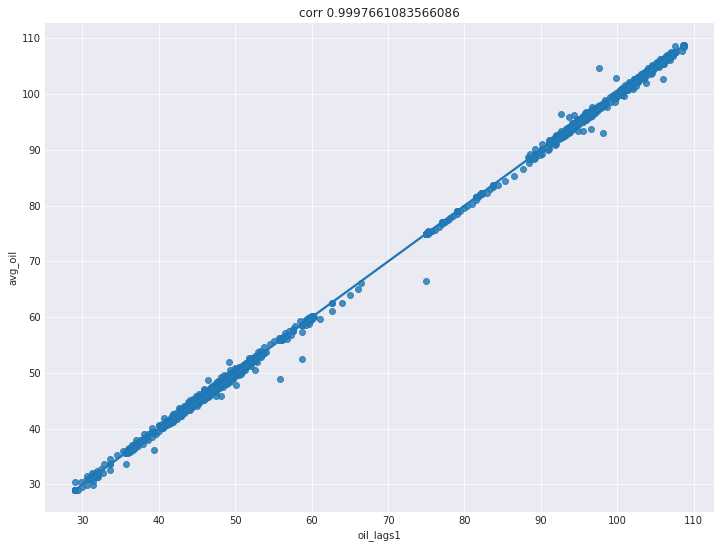

In [11]:
lag = 'oil_lags1'
plt.figure()
sns.regplot(x = calendar[lag], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag])}')
plt.show()

# Fetching holiday dataset

In [12]:
hol = pd.read_csv('../input/holidays_events.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
hol = hol[hol.locale == 'National'] # I'm only taking National holiday so there's no false positive.
hol = hol.groupby(hol.index).first() # Removing duplicated holiday at the same date
hol

,type,locale,locale_name,description,transferred
date,,,,,
2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


# Feature Engineering for holiday

In [13]:
calendar = calendar.join(hol) # Joining calendar with holiday dataset
calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = 1
calendar.loc[calendar.dofw > 4, 'wd'] = 0 # If it's saturday or sunday then it's not Weekday
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 # If it's Work Day event then it's a workday
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 # If it's Transfer event then it's not a work day
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 # If it's Bridge event then it's not a work day
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 # If it's holiday and the holiday is not transferred then it's holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 # If it's holiday and transferred then it's not holiday
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) # One-hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['type']) # One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns
calendar

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-01,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0
2013-01-02,NaN,NaN,NaN,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-03,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-04,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-01-05,NaN,NaN,NaN,NaN,1,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-08-28,47.624286,47.720000,47.720000,47.720000,1,0,0,0,0,0,0,0,0,0,0,0,0
2017-08-29,47.320000,47.624286,47.720000,47.720000,1,1,0,0,0,0,0,0,0,0,0,0,0
2017-08-30,47.115714,47.320000,47.624286,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0


In [14]:
calendar['type_Event'].value_counts()

0    1651
1      53
Name: type_Event, dtype: int64

In [15]:
calendar['type_Bridge'].value_counts()

0    1701
1       3
Name: type_Bridge, dtype: int64

In [16]:
calendar['type_Holiday'].value_counts()

0    1653
1      51
Name: type_Holiday, dtype: int64

In [17]:
calendar['type_Transfer'].value_counts()

0    1697
1       7
Name: type_Transfer, dtype: int64

In [18]:
calendar['type_Work Day'].value_counts()

0    1699
1       5
Name: type_Work Day, dtype: int64

In [19]:
#calendar['wd_lag1'] = calendar.wd.shift(1)
#calendar['wd_fore1'] = calendar.wd.shift(-1).fillna(0)
#calendar.dropna(inplace = True)
#calendar

# Dependent Variable Viz

In [20]:
#y = train.unstack(['store_nbr', 'family']).loc['2016-06':'2017']
#family = {c[2] for c in train.index}
#for f in family :
#    ax = y.loc(axis = 1)['sales', :, f].plot(legend = None)
#    ax.set_title(f)

Graphs above are the visualization of each product

In [21]:
sdate = '2013-01-01' # Start and end of training date
edate = '2017-08-31'

In [22]:
school_season = [] # Feature for school fluctuations
for i, r in calendar.iterrows() :
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season
calendar

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2013-01-01,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-02,NaN,NaN,NaN,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-04,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-05,NaN,NaN,NaN,NaN,1,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2017-08-28,47.624286,47.720000,47.720000,47.720000,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-29,47.320000,47.624286,47.720000,47.720000,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-30,47.115714,47.320000,47.624286,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0,1


# DeterministicProcess

In [23]:
#x = dp.in_sample()
#x = x.join(calendar)
x = calendar

# Using LinearRegression to make a generalized line (It's usually called blending.)

# ここから、特徴量をまとめる

In [24]:
#現在の最大表示列数の出力
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

In [25]:
print(x.shape)
x.head()

(1704, 18)


,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2013-01-01,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-02,NaN,NaN,NaN,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-04,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-05,NaN,NaN,NaN,NaN,1,0,0,0,0,1,0,0,0,0,0,0,1,0


In [26]:
#y

In [27]:
x

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2013-01-01,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-02,NaN,NaN,NaN,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-04,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-05,NaN,NaN,NaN,NaN,1,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2017-08-28,47.624286,47.720000,47.720000,47.720000,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-29,47.320000,47.624286,47.720000,47.720000,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-30,47.115714,47.320000,47.624286,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [28]:
x.columns

Index(['avg_oil', 'oil_lags1', 'oil_lags2', 'oil_lags3', 'wd', 'dofw_1',
       'dofw_2', 'dofw_3', 'dofw_4', 'dofw_5', 'dofw_6', 'type_Additional',
       'type_Bridge', 'type_Event', 'type_Holiday', 'type_Transfer',
       'type_Work Day', 'school_season'],
      dtype='object')

In [29]:
features = ['avg_oil',
            'wd',
            'dofw_1',
            'dofw_2',
            'dofw_3',
            'dofw_4',
            'dofw_5',
            'dofw_6',
            'type_Additional',
            #'type_Bridge',
            'type_Event',
            'type_Holiday',
            #'type_Transfer',
            #'type_Work Day',
            'school_season']

In [30]:
x

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2013-01-01,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-02,NaN,NaN,NaN,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-04,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-05,NaN,NaN,NaN,NaN,1,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2017-08-28,47.624286,47.720000,47.720000,47.720000,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-29,47.320000,47.624286,47.720000,47.720000,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-30,47.115714,47.320000,47.624286,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [31]:
x.index.name="date"

In [32]:

df_feat = x[features].reset_index()

In [33]:
df_feat['date'] = df_feat['date'].astype('str')

In [34]:
df_feat.dtypes

date                object
avg_oil            float64
wd                   int64
dofw_1               uint8
dofw_2               uint8
dofw_3               uint8
dofw_4               uint8
dofw_5               uint8
dofw_6               uint8
type_Additional      uint8
type_Event           uint8
type_Holiday         uint8
school_season        int64
dtype: object

In [35]:
df_train = pd.read_csv('../input/train.csv')

In [36]:
df_test = pd.read_csv('../input/test.csv')

In [37]:
df_tr_te = pd.concat([df_train, df_test]).reset_index(drop=True)

In [38]:
df_tr_te.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [39]:
df_feat.dtypes

date                object
avg_oil            float64
wd                   int64
dofw_1               uint8
dofw_2               uint8
dofw_3               uint8
dofw_4               uint8
dofw_5               uint8
dofw_6               uint8
type_Additional      uint8
type_Event           uint8
type_Holiday         uint8
school_season        int64
dtype: object

In [40]:
df_feat

,date,avg_oil,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Event,type_Holiday,school_season
0,2013-01-01,NaN,0,1,0,0,0,0,0,0,0,1,0
1,2013-01-02,NaN,1,0,1,0,0,0,0,0,0,0,0
2,2013-01-03,NaN,1,0,0,1,0,0,0,0,0,0,0
3,2013-01-04,NaN,1,0,0,0,1,0,0,0,0,0,0
4,2013-01-05,NaN,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2017-08-27,47.720000,0,0,0,0,0,0,1,0,0,0,1
1700,2017-08-28,47.624286,1,0,0,0,0,0,0,0,0,0,1
1701,2017-08-29,47.320000,1,1,0,0,0,0,0,0,0,0,1
1702,2017-08-30,47.115714,1,0,1,0,0,0,0,0,0,0,1


In [41]:
df_mrg = df_tr_te.merge(df_feat, how='left')

In [42]:
df_mrg[df_mrg.date=='2013-01-13']

,id,date,store_nbr,family,sales,onpromotion,avg_oil,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Event,type_Holiday,school_season
21384,21384,2013-01-13,1,AUTOMOTIVE,2.000,0,93.284286,0,0,0,0,0,0,1,0,0,0,0
21385,21385,2013-01-13,1,BABY CARE,0.000,0,93.284286,0,0,0,0,0,0,1,0,0,0,0
21386,21386,2013-01-13,1,BEAUTY,0.000,0,93.284286,0,0,0,0,0,0,1,0,0,0,0
21387,21387,2013-01-13,1,BEVERAGES,572.000,0,93.284286,0,0,0,0,0,0,1,0,0,0,0
21388,21388,2013-01-13,1,BOOKS,0.000,0,93.284286,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23161,23161,2013-01-13,9,POULTRY,540.596,0,93.284286,0,0,0,0,0,0,1,0,0,0,0
23162,23162,2013-01-13,9,PREPARED FOODS,88.000,0,93.284286,0,0,0,0,0,0,1,0,0,0,0
23163,23163,2013-01-13,9,PRODUCE,0.000,0,93.284286,0,0,0,0,0,0,1,0,0,0,0
23164,23164,2013-01-13,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,93.284286,0,0,0,0,0,0,1,0,0,0,0


In [43]:
df_mrg

,id,date,store_nbr,family,sales,onpromotion,avg_oil,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Event,type_Holiday,school_season
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,0,1,0,0,0,0,0,0,0,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,0,1,0,0,0,0,0,0,0,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,0,1,0,0,0,0,0,0,0,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,0,1,0,0,0,0,0,0,0,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,47.06,1,0,0,1,0,0,0,0,0,0,1
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,47.06,1,0,0,1,0,0,0,0,0,0,1
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,47.06,1,0,0,1,0,0,0,0,0,0,1
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,47.06,1,0,0,1,0,0,0,0,0,0,1


In [44]:
### target用
df_mrg[df_mrg.date < '2017-08-16'][['date','store_nbr','family','sales']].to_csv('../input_for_forecast2/target.csv',index=False, header=False)
df_mrg[df_mrg.date < '2017-08-16'][['date','store_nbr','family','sales']]


,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000
1,2013-01-01,1,BABY CARE,0.000
2,2013-01-01,1,BEAUTY,0.000
3,2013-01-01,1,BEVERAGES,0.000
4,2013-01-01,1,BOOKS,0.000
...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133
3000884,2017-08-15,9,PREPARED FOODS,154.553
3000885,2017-08-15,9,PRODUCE,2419.729
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000


In [45]:
### related用
df_mrg[['date','store_nbr','family','onpromotion'] + features].to_csv('../input_for_forecast2/related.csv',index=False, header=False)
df_mrg[['date','store_nbr','family','onpromotion'] + features]

,date,store_nbr,family,onpromotion,avg_oil,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Event,type_Holiday,school_season
0,2013-01-01,1,AUTOMOTIVE,0,NaN,0,1,0,0,0,0,0,0,0,1,0
1,2013-01-01,1,BABY CARE,0,NaN,0,1,0,0,0,0,0,0,0,1,0
2,2013-01-01,1,BEAUTY,0,NaN,0,1,0,0,0,0,0,0,0,1,0
3,2013-01-01,1,BEVERAGES,0,NaN,0,1,0,0,0,0,0,0,0,1,0
4,2013-01-01,1,BOOKS,0,NaN,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,47.06,1,0,0,1,0,0,0,0,0,0,1
3029396,2017-08-31,9,PREPARED FOODS,0,47.06,1,0,0,1,0,0,0,0,0,0,1
3029397,2017-08-31,9,PRODUCE,1,47.06,1,0,0,1,0,0,0,0,0,0,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.06,1,0,0,1,0,0,0,0,0,0,1


In [46]:
['date','store_nbr','family','onpromotion'] + features

['date',
 'store_nbr',
 'family',
 'onpromotion',
 'avg_oil',
 'wd',
 'dofw_1',
 'dofw_2',
 'dofw_3',
 'dofw_4',
 'dofw_5',
 'dofw_6',
 'type_Additional',
 'type_Event',
 'type_Holiday',
 'school_season']

# Autopilot向けデータ作成

## 学習用

In [47]:
df_mrg[df_mrg.date < '2017-08-16'][['date','store_nbr','family','sales','onpromotion'] + features].to_csv('../input_for_autopilot/train.csv',index=False, header=True)

In [48]:
df_mrg[df_mrg.date >= '2017-08-16'][['date','store_nbr','family','onpromotion'] + features].to_csv('../input_for_autopilot/test.csv',index=False, header=True)

# sales 対数変換したバージョン

In [49]:
df_mrg_log1p = df_mrg[df_mrg.date < '2017-08-16'][['date','store_nbr','family','sales','onpromotion'] + features]

In [50]:
import numpy as np
df_mrg_log1p['sales'] = np.log1p(df_mrg_log1p['sales'])

In [51]:
df_mrg_log1p[df_mrg_log1p.date < '2017-08-16'][['date','store_nbr','family','sales','onpromotion'] + features].to_csv('../input_for_autopilot/train_log1p.csv',index=False, header=True)